# **Character-Level Recurrent Neural Network Language Model**

## **From Scratch Implementation in NumPy**

This notebook implements a **vanilla RNN** for character-level language modeling, following the approach pioneered by Andrej Karpathy in his seminal blog post *"The Unreasonable Effectiveness of Recurrent Neural Networks"* (2015).


### **What We'll Build:**
- **Vanilla RNN** with tanh activation
- **Backpropagation Through Time (BPTT)** for gradient computation
- **Adam optimizer** for parameter updates
- **Character-level text generation** from learned patterns
---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025*  
*License: MIT*

In [1]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

### __DATA I/O__
We will use `Thirsty Crow` story as our small training data.

In [2]:
#Load Data
data = open('../data/thirsty_crow.txt', 'r').read()
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print(f'Data has {data_size} characters, {vocab_size} unique.')

Data has 677 characters, 33 unique.


In [3]:
char_to_ix = {ch:i for i,ch in enumerate(chars)}

In [4]:
ix_to_char = {i:ch for i,ch in enumerate(chars)}

**Understanding the Mappings:**
- `char_to_ix`: Maps ```{'a': 0, 'b': 1, ..., 'z' → 25}``` etc.
- `ix_to_char`: Reverse mapping: ```{0: 'a', 1: 'b', ..., 25 → 'z'}```, etc.

**Example:** The word "cat" becomes `[2, 0, 19]` if ```{'c' :2, 'a' :0, 't' :19}``` in our vocabulary.

### __HYPER-PARAMETERS__

In [5]:
lr = 1e-3 # learning rate
seq_len = 25 # times RNN will be unrolled (Timesteps)
hidden_size= 100 # size of hidden units

**Hyperparameter Guide:**

- **`lr` (learning rate)**: Step size for gradient descent
  - Too high → divergence, loss explodes
  - Too low → slow convergence
  - Adam typically: 1e-3 to 1e-4
  
- **`seq_len` (sequence length)**: Number of characters processed at once
  - Longer → captures more context, but harder to train (vanishing gradients)
  - Typical range: 20-50 for character-level models
  
- **`hidden_size`**: Model capacity (memory)
  - Larger → more expressive, but risk of overfitting
  - Karpathy used 100-512 for various tasks
  - Rule of thumb: Start with 100, increase if underfitting

### __MODEL PARAM INIT__
**Initializing weight matrices for the RNN.**

- $\mathbf{W}_{xh} \in \mathbb{R}^{H \times V}$ Input-to-hidden weights
- $\mathbf{W}_{hh} \in \mathbb{R}^{H \times H}$ Hidden-to-hidden (recurrent) weights
- $\mathbf{W}_{hy} \in \mathbb{R}^{V \times H}$ Hidden-to-output weights
- $\mathbf{b}_h \in \mathbb{R}^{H \times 1}$ Hidden bias
- $\mathbf{b}_y \in \mathbb{R}^{V \times 1}$ Output bias

**Where:**  
- $H$ = hidden size  
- $V$ = vocabulary size

In [6]:
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden (H, V)
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden (H, H)
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output (V, H)
bh = np.zeros((hidden_size, 1)) # hidden bias (H, 1)
by = np.zeros((vocab_size, 1)) # output bias (V, 1)

In [7]:
print(f"""
Wxh: Input to hidden  : {Wxh.shape}
Whh: Hidden to hidden : {Whh.shape}
Why: Hidden to output : {Why.shape}
bh: Hidden bias       : {bh.shape}
by: Output bias       : {by.shape}
""")


Wxh: Input to hidden  : (100, 33)
Whh: Hidden to hidden : (100, 100)
Why: Hidden to output : (33, 100)
bh: Hidden bias       : (100, 1)
by: Output bias       : (33, 1)



### __ADAM OPTIMIZER INITIALIZATION__

**Adam** (Adaptive Moment Estimation) is a modern optimizer that adapts learning rates for each parameter.

**Reference:** Kingma & Ba (2014) - *Adam: A Method for Stochastic Optimization*

In [8]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Adam memory variables (first moment - momentum)
mWxh = np.zeros_like(Wxh)
mWhh = np.zeros_like(Whh)
mWhy = np.zeros_like(Why)
mbh = np.zeros_like(bh)
mby = np.zeros_like(by)

# Adam memory variables (second moment - RMSprop)
vWxh = np.zeros_like(Wxh)
vWhh = np.zeros_like(Whh)
vWhy = np.zeros_like(Why)
vbh = np.zeros_like(bh)
vby = np.zeros_like(by)

# Timestep counter for bias correction
t_adam = 0

**What are these variables?**

- **`m*` (first moment)**: Running average of gradients → provides momentum
  - Helps accelerate convergence in relevant directions
  - Reduces oscillations
  
- **`v*` (second moment)**: Running average of squared gradients → adaptive learning rates
  - Automatically scales learning rate for each parameter
  - Large gradients → smaller effective learning rate
  - Small gradients → larger effective learning rate
  
- **`t_adam`**: Iteration counter for bias correction
  - Early in training, m and v are biased toward zero
  - Correction: $\hat{m}_t = m_t / (1 - \beta_1^t)$, $\hat{v}_t = v_t / (1 - \beta_2^t)$

### __SINGLE VANILLA RNN CELL__

**Forward pass equations:**

$$
\begin{align}
\mathbf{z}_t &= \mathbf{W}_{xh} \mathbf{x}_t + \mathbf{W}_{hh} \mathbf{h}_{t-1} + \mathbf{b}_h \quad &\text{(pre-activation)} \\
\mathbf{h}_t &= \tanh(\mathbf{z}_t) \quad &\text{(hidden state)} \\
\mathbf{y}_t &= \mathbf{W}_{hy} \mathbf{h}_t + \mathbf{b}_y \quad &\text{(output logits)}
\end{align}
$$

**Reference:** Elman (1990) - *Finding Structure in Time*

In [9]:
def rnn(x_prev, h_prev):
    """
    Single RNN cell with embedding lookup

    Inputs:
        - x_prev: Previous input character (one-hot vector)
        - h_prev: Previous hidden state (H,1)

    Returns:
        - ht: Current hidden state (H, 1)
        - yt: Output logits (V, 1)\
    """
    zt = np.dot(Wxh, x_prev) + np.dot(Whh, h_prev) + bh
    # (H,V) @ (V,1) -> (H,1) + (H,1) <- (H,H) @ (H,1) + (H,1) = (H,1)
    ht = np.tanh(zt) # (H,1)
    yt = np.dot(Why, ht) + by # (V,H)@(H,1) -> (V,1) + (V,1) = (V,1)
    return ht, yt

**Understanding the RNN Cell:**

**What's happening here?**
- At each timestep $t$, the RNN takes two inputs:
  1. Current character $\mathbf{x}_t$ (one-hot vector)
  2. Previous memory $\mathbf{h}_{t-1}$ (hidden state from last step)
  
- It outputs:
  1. New memory $\mathbf{h}_t$ (encodes everything seen so far)
  2. Prediction $\mathbf{y}_t$ (logits for next character)

**The "recurrent" part:** $\mathbf{h}_t$ depends on $\mathbf{h}_{t-1}$, creating a feedback loop through time.

### __FORWARD PASS__


In [10]:
def forward(inputs, targets, h_prev):
    """
    Forward pass through unrolled RNN

    Inputs:
        - inputs: List of character indices, e.g., [5, 8, 12, 12, 15] for "hello"
        - targets: List of target character indices (inputs shifted by 1)
        - h_prev: Initial hidden state from previous sequence, shape (H, 1)

    Returns:
        - xt: Dict of one-hot inputs {0: x_0, 1: x_1, ...}
        - ht: Dict of hidden states {-1: h_init, 0: h_0, 1: h_1, ...}
        - yt: Dict of output logits {0: y_0, 1: y_1, ...}
        - probt: Dict of probability distributions {0: p_0, 1: p_1, ...}
        - loss: Total cross-entropy loss across all timesteps (scalar)
    """
    # Initialize storage dictionaries
    xt = {}  # Store one-hot encoded inputs
    ht = {}  # Store hidden states
    yt = {}  # Store raw outputs (before softmax)
    probt = {}  # Store probability distributions (after softmax)

    # Set initial hidden state
    ht[-1] = np.copy(h_prev) #(H,1)
    loss = 0
    # Loop through each timestep in the sequence
    for t in range(len(inputs)):
        # Step 1: Convert character index to one-hot vector
        xt[t] = np.zeros((vocab_size, 1)) #(V,1)
        xt[t][inputs[t]] = 1  # Set the position of char to 1, (V,1)

        # Step 2: Run RNN cell (forward computation)
        ht[t], yt[t] = rnn(xt[t], ht[t-1]) # (H,1), (V,1)

        # Step 3: Apply softmax to get probabilities (Subtract max for stability)
        exp_scores = np.exp(yt[t] - np.max(yt[t])) # (V,1)
        probt[t] = exp_scores / np.sum(exp_scores) # (V,1)

        # Step 4: Compute loss for this timestep
        # Cross-entropy: -log(probability of correct next character)
        loss += -np.log(probt[t][targets[t], 0]+ epsilon)
    return xt, ht, probt, loss

**Deep Dive: Understanding the Forward Pass**

**1. Why one-hot encoding?**
```python
# If vocab = ['a', 'b', 'c', ..., 'z'] and char_to_ix = {'a':0, 'b':1, ...}
# Character 'c' (index 2) becomes:
xt[t] = [0, 0, 1, 0, 0, ..., 0]  # 1 at position 2, zeros elsewhere
```

**2. Cross-Entropy Loss Formula**

$$\mathcal{L}_t = -\log p_t[y^*_t]$$

Where:
- $p_t$: Probability distribution at time $t$ (output of softmax)

- $y^*_t$: Correct next character (target)
- Lower loss → model assigns higher probability to correct character

**Total loss:** $\mathcal{L} = \sum_{t=0}^{T-1} \mathcal{L}_t$

**3. Why maintain hidden state?**

The hidden state $\mathbf{h}_t$ acts as the network's "memory":
- Encodes information about all characters seen so far
- Enables the model to learn long-term dependencies
- Without it, predictions would be independent at each position!

**Example:** To predict the next word in "The cat sat on the ___", the model needs to remember "cat" from earlier in the sequence.

### __BACKWARD PASS__
**Complete BPTT Equations (As Implemented Below In Code):**

**Step 1: Output Gradient (Softmax + Cross-Entropy)**
$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

**Step 2: Output Weight Gradients**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{hy}} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} \mathbf{h}_t^T, \quad \frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

**Step 3: Hidden State Gradient (Two Sources!)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} = \mathbf{W}_{hy}^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t+1}}$$

**Step 4: Pre-Activation Gradient (Tanh)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot (1 - \mathbf{h}_t^2)$$
**Step 5: Hidden Weight Gradients (Accumulated)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{xh}} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} \mathbf{x}_t^T, \quad \frac{\partial \mathcal{L}}{\partial \mathbf{W}_{hh}} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} \mathbf{h}_{t-1}^T$$
**Step 6: Gradient to Previous Timestep**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}} = \mathbf{W}_{hh}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t}$$
**Visual:** Gradients flow backward from $t=T-1 \rightarrow 0$, accumulating contributions from all timesteps.

In [11]:
def backward(inputs, targets, xt, ht, probt):
    """
    Backpropagation Through Time (BPTT)

    Inputs:
        - inputs: List of input character indices
        - targets: List of target character indices
        - xt: Dict of one-hot inputs from forward pass
        - ht: Dict of hidden states from forward pass
        - probt: Dict of probability distributions from forward pass

    Returns:
        - dWxh: Gradient w.r.t. input-to-hidden weights, shape (H, V)
        - dWhh: Gradient w.r.t. hidden-to-hidden weights, shape (H, H)
        - dWhy: Gradient w.r.t. hidden-to-output weights, shape (V, H)
        - dbh: Gradient w.r.t. hidden bias, shape (H, 1)
        - dby: Gradient w.r.t. output bias, shape (V, 1)
    """

    # Initialize gradients to zero
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)

    # Gradient of hidden state at next timestep (initially zero)
    dh_next = np.zeros_like(ht[0]) # (H,1)

    # Backpropagate through time (from last to first timestep)
    for t in reversed(range(len(inputs))):
        # Step 1: Gradient of loss w.r.t output probabilities
        dy = np.copy(probt[t]) #(V,1)
        dy[targets[t]] -= 1  # Subtract 1 from correct class (cross-entropy gradient), dy[correct_class] = dy[correct_class] - 1, (V,1)

        # Step 2: Gradients for output layer (Why, by)
        dWhy += np.dot(dy, ht[t].T) # (V,1)@(H,1)-> (1,H) = (V,H)
        dby += dy # (V,1)

        # Step 3: Gradient w.r.t hidden state
        # Comes from two sources: current output and next timestep
        dh = np.dot(Why.T, dy) + dh_next # (V,H)-> (H,V)@(V,1)=(H,1)+(H,1)=(H,1)

        # Step 4: Gradient through tanh activation
        dzt = (1 - ht[t]**2) * dh  #(H,1)*(H,1)=(H,1)

        # Step 5: Gradients for hidden layer (Wxh, Whh, bh)
        dWxh += np.dot(dzt, xt[t].T) #(H,1)@(V,1)->(1,V)=(H,V)
        dWhh += np.dot(dzt, ht[t-1].T) #(H,1)@(H,1)->(1,H)=H,H
        dbh += dzt #(H,1)

        # Step 6: Pass gradient to previous timestep
        dh_next = np.dot(Whh.T, dzt) #(H,H)@(H,1)=(H,1)

    # Clip gradients to prevent exploding gradients
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dWxh, dWhh, dWhy, dbh, dby

**Understanding BPTT: The Gradient Flow**

**1. The Softmax-CrossEntropy Gradient**

For softmax activation with cross-entropy loss, the gradient simplifies to:

$$\frac{\partial \mathcal{L}}{\partial \mathbf{y}} = \mathbf{p} - \mathbf{1}_{y^*}$$

Where $\mathbf{1}_{y^*}$ is the one-hot vector of the target.

**Example:** If vocab_size=5 and target=2:
```python
probt[t] = [0.1, 0.2, 0.6, 0.05, 0.05]  # Model's prediction
target = 2  # Correct class
dy = [0.1, 0.2, -0.4, 0.05, 0.05]  # Gradient (0.6 - 1 = -0.4 at position 2)
```

**2. Why Gradient Clipping?**

RNNs suffer from **exploding gradients** because:
- Gradients are multiplied by $\mathbf{W}_{hh}$ at each timestep
- Over many timesteps: $(\mathbf{W}_{hh})^T \cdot (\mathbf{W}_{hh})^T \cdot ... \cdot (\mathbf{W}_{hh})^T$
- If largest eigenvalue of $\mathbf{W}_{hh}$ > 1 → exponential growth
- Clipping prevents: `loss = nan`, `weights = inf`

**3. Gradient Accumulation**

Notice `+=` instead of `=`:
```python
dWxh += np.dot(dzt, xt[t].T)  # Accumulate across timesteps
```
We sum gradients from all timesteps because the same weights are shared across time!

**4. Tanh Derivative: Why (1 - h²)?**
$$\therefore h_t = tanh(z)$$
$$\frac{d}{dz}\tanh(z) = 1 - \tanh^2(z) = 1 - h^2$$

**Vanishing Gradient Problem:** When $|h_t| \approx 1$, derivative $\approx 0$ → gradients vanish.
This is why LSTMs/GRUs were invented!

### __UPDATE PARAMS WITH ADAM__

In [12]:
def update_parameters(dWxh, dWhh, dWhy, dbh, dby, learning_rate):
    """
    Update model parameters using Adam optimizer

    Inputs:
        - dWxh: Gradient for input-to-hidden weights (H, V)
        - dWhh: Gradient for hidden-to-hidden weights (H, H)
        - dWhy: Gradient for hidden-to-output weights (V, H)
        - dbh: Gradient for hidden bias (H, 1)
        - dby: Gradient for output bias (V, 1)
        - learning_rate: Step size for parameter updates

    Returns:
        - None (updates global parameters in-place)
    """
    global Wxh, Whh, Why, bh, by
    global mWxh, mWhh, mWhy, mbh, mby
    global vWxh, vWhh, vWhy, vbh, vby
    global t_adam

    # Increment timestep
    t_adam += 1

    # Update Wxh
    mWxh = beta1 * mWxh + (1 - beta1) * dWxh
    vWxh = beta2 * vWxh + (1 - beta2) * (dWxh ** 2)
    mWxh_corrected = mWxh / (1 - beta1 ** t_adam)
    vWxh_corrected = vWxh / (1 - beta2 ** t_adam)
    Wxh -= learning_rate * mWxh_corrected / (np.sqrt(vWxh_corrected) + epsilon)

    # Update Whh
    mWhh = beta1 * mWhh + (1 - beta1) * dWhh
    vWhh = beta2 * vWhh + (1 - beta2) * (dWhh ** 2)
    mWhh_corrected = mWhh / (1 - beta1 ** t_adam)
    vWhh_corrected = vWhh / (1 - beta2 ** t_adam)
    Whh -= learning_rate * mWhh_corrected / (np.sqrt(vWhh_corrected) + epsilon)

    # Update Why
    mWhy = beta1 * mWhy + (1 - beta1) * dWhy
    vWhy = beta2 * vWhy + (1 - beta2) * (dWhy ** 2)
    mWhy_corrected = mWhy / (1 - beta1 ** t_adam)
    vWhy_corrected = vWhy / (1 - beta2 ** t_adam)
    Why -= learning_rate * mWhy_corrected / (np.sqrt(vWhy_corrected) + epsilon)

    # Update bh
    mbh = beta1 * mbh + (1 - beta1) * dbh
    vbh = beta2 * vbh + (1 - beta2) * (dbh ** 2)
    mbh_corrected = mbh / (1 - beta1 ** t_adam)
    vbh_corrected = vbh / (1 - beta2 ** t_adam)
    bh -= learning_rate * mbh_corrected / (np.sqrt(vbh_corrected) + epsilon)

    # Update by
    mby = beta1 * mby + (1 - beta1) * dby
    vby = beta2 * vby + (1 - beta2) * (dby ** 2)
    mby_corrected = mby / (1 - beta1 ** t_adam)
    vby_corrected = vby / (1 - beta2 ** t_adam)
    by -= learning_rate * mby_corrected / (np.sqrt(vby_corrected) + epsilon)

### __TRAIN MODEL__


In [13]:
def train(data, num_iterations=1000, print_every=100, sample_every=100):
    """
    Train RNN language model using Adam optimizer

    Inputs:
        - data: String of training text
        - num_iterations: Number of training iterations (not full data passes)
        - print_every: Print loss every N iterations
        - sample_every: Generate sample text every N iterations

    Returns:
        - smooth_loss: Exponentially smoothed loss value

    Note: Hidden state h_prev is maintained across sequences for temporal continuity.
        Only reset when reaching end of data or on first iteration.
    """
    smooth_loss = -np.log(1.0 / vocab_size) * seq_len
    losses = []
    n = 0  # Iteration counter
    p = 0  # Data pointer (position in text)
    h_prev = np.zeros((hidden_size, 1))

    while n < num_iterations:
        # Reset pointer and hidden state at end of data or first iteration
        if p + seq_len + 1 >= len(data) or n == 0:
            h_prev = np.zeros((hidden_size, 1))  # Fresh start
            p = 0  # Go back to beginning

        # Input:  characters at positions [p, p+1, ..., p+seq_len-1]
        # Target: characters at positions [p+1, p+2, ..., p+seq_len]
        inputs = [char_to_ix[ch] for ch in data[p:p+seq_len]]
        targets = [char_to_ix[ch] for ch in data[p+1:p+seq_len+1]]
        # Forward pass (pass hidden state!)
        xt, ht, probt, loss = forward(inputs, targets, h_prev)
        # Update hidden state for next sequence
        h_prev = np.copy(ht[len(inputs) - 1])
        # Backward pass
        dWxh, dWhh, dWhy, dbh, dby = backward(inputs, targets,xt, ht, probt)
        # Update parameters
        update_parameters(dWxh, dWhh, dWhy, dbh, dby, lr)
        # Update smooth loss
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        # Print progress
        if n % print_every == 0:
            print(f"Iter {n:6d} | Loss: {smooth_loss:.4f}")
        # Generate sample text
        if n % sample_every == 0 and n > 0:
            print(f"\n{'='*60}")
            print(f"SAMPLE at iteration {n}:")
            print(f"{'='*60}")
            sample_text = sample(data[0], n_chars=200)
            print(sample_text)
            print(f"{'='*60}\n")
        p += seq_len
        n += 1

    print("\nTraining complete!")
    return smooth_loss, losses

**Training Deep Dive: What's Really Happening?**

**The Training Loop Flow:**

```
Initialize: h = zeros(100, 1)

Iteration 1:
  Data: "Once upon a time, on a ve"
  → Forward: Get loss, store states
  → h_prev = h[24]  ← Keep this for next iteration!
  → Backward: Compute gradients
  → Adam: Update weights

Iteration 2:
  Data: "ry hot day, a thirsty cro"
  → Forward with h_prev from iteration 1  ← CONTINUITY!
  → ...
```

**Why This Works:**

1. **Hidden state continuity** lets the model learn long-range dependencies across sequence boundaries
2. **Sliding window** ensures we see all the data
3. **Adam optimizer** adapts learning rates automatically
4. **Gradient clipping** prevents explosion
5. **Smooth loss** gives us a stable metric to monitor

**Common Pitfall:** Resetting hidden state too frequently breaks temporal learning!

### __SAMPLING FUNCTION (GENERATE TEXT)__

In [14]:
def sample(seed_char, n_chars=100):
    """
    Generate text by sampling from the trained RNN language model

    Inputs:
        - seed_char: Starting character for text generation
        - n_chars: Number of characters to generate (default 100)

    Returns:
        - String of generated text starting with seed_char

    Note: Uses stochastic sampling from probability distribution (not argmax).
          Numerically stable softmax implementation with max subtraction.
    """
    if seed_char not in char_to_ix:
        if seed_char.lower() in char_to_ix:
            seed_char = seed_char.lower()
        else:
            seed_char = data[0]
            print(f"Warning: Seed not in vocab. Using '{seed_char}' instead")

    x = np.zeros((vocab_size, 1)) # Convert seed character to index
    x[char_to_ix[seed_char]] = 1
    h = np.zeros((hidden_size, 1)) # Initialize hidden state
    generated_chars = [seed_char] # Store generated characters

    for _ in range(n_chars):
        h, y = rnn(x, h)
        p = np.exp(y - np.max(y)) / np.sum(np.exp(y - np.max(y)))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        char = ix_to_char[ix]
        generated_chars.append(char)
        x = np.zeros((vocab_size, 1))
        x[ix] = 1

    return ''.join(generated_chars)

**Understanding Text Generation**

**Example:** Suppose after "Once upon a t", the model outputs probabilities:

```python
Characters: ['a', 'h', 'i', 'm', 'o', ...]
Probabilities: [0.02, 0.65, 0.25, 0.05, 0.01, ...]
```

**Greedy Decoding (argmax):** Always pick 'h' → "Once upon a th" → then always 'e' → "Once upon a the the the..." based on character with highest probability each time.

**Sampling:**
- 65% chance pick 'h' → "Once upon a time"
- 25% chance pick 'i' → "Once upon a time"  
- 5% chance pick 'm' → "Once upon a time"
- ...more diverse output!

**Why Fresh Hidden State?**
When generating, we start with `h = zeros()` because:
1. We're creating NEW text, not continuing training data
2. Starting fresh avoids bias from training sequences
3. The model will build up context as it generates

**Quality:**
- Early in training: Gibberish ("xqz kpt uwm...")
- Mid training: Recognizable patterns ("the cat wat on...")
- Late training: Coherent text ("the cat sat on the mat")

### __RUN TRAINING__

In [15]:
_, loss = train(data, num_iterations=50000, print_every=1000, sample_every=5000)

Iter      0 | Loss: 87.4127
Iter   1000 | Loss: 68.4298
Iter   2000 | Loss: 40.6549
Iter   3000 | Loss: 19.9702
Iter   4000 | Loss: 10.4223
Iter   5000 | Loss: 4.5660

SAMPLE at iteration 5000:
Once upon a time, on a very hot day he tot ane. The crow tho pily, cow sinkint y aag hed ily, crong and flowd inen on ide
!ThH criagly he water.
He felt refreap h  aly, a thel hd tte wasea hited ade. T

Iter   6000 | Loss: 3.6948
Iter   7000 | Loss: 1.6394
Iter   8000 | Loss: 0.7420
Iter   9000 | Loss: 0.3549
Iter  10000 | Loss: 2.0044

SAMPLE at iteration 10000:
Once upon a time, on a very hot dry, a tome huthide.

Aftea pith, crow was feeling tired and weak.

After flting for a long time, the crow finally saw a pitcher lying under a tree. He quickly flew dofl

Iter  11000 | Loss: 0.8710
Iter  12000 | Loss: 0.3947
Iter  13000 | Loss: 0.1915
Iter  14000 | Loss: 0.0995
Iter  15000 | Loss: 0.0545

SAMPLE at iteration 15000:
Once upon a time, on a very hot day, a thirsty crow was flying in search o

### __PLOT LOSS CURVE__

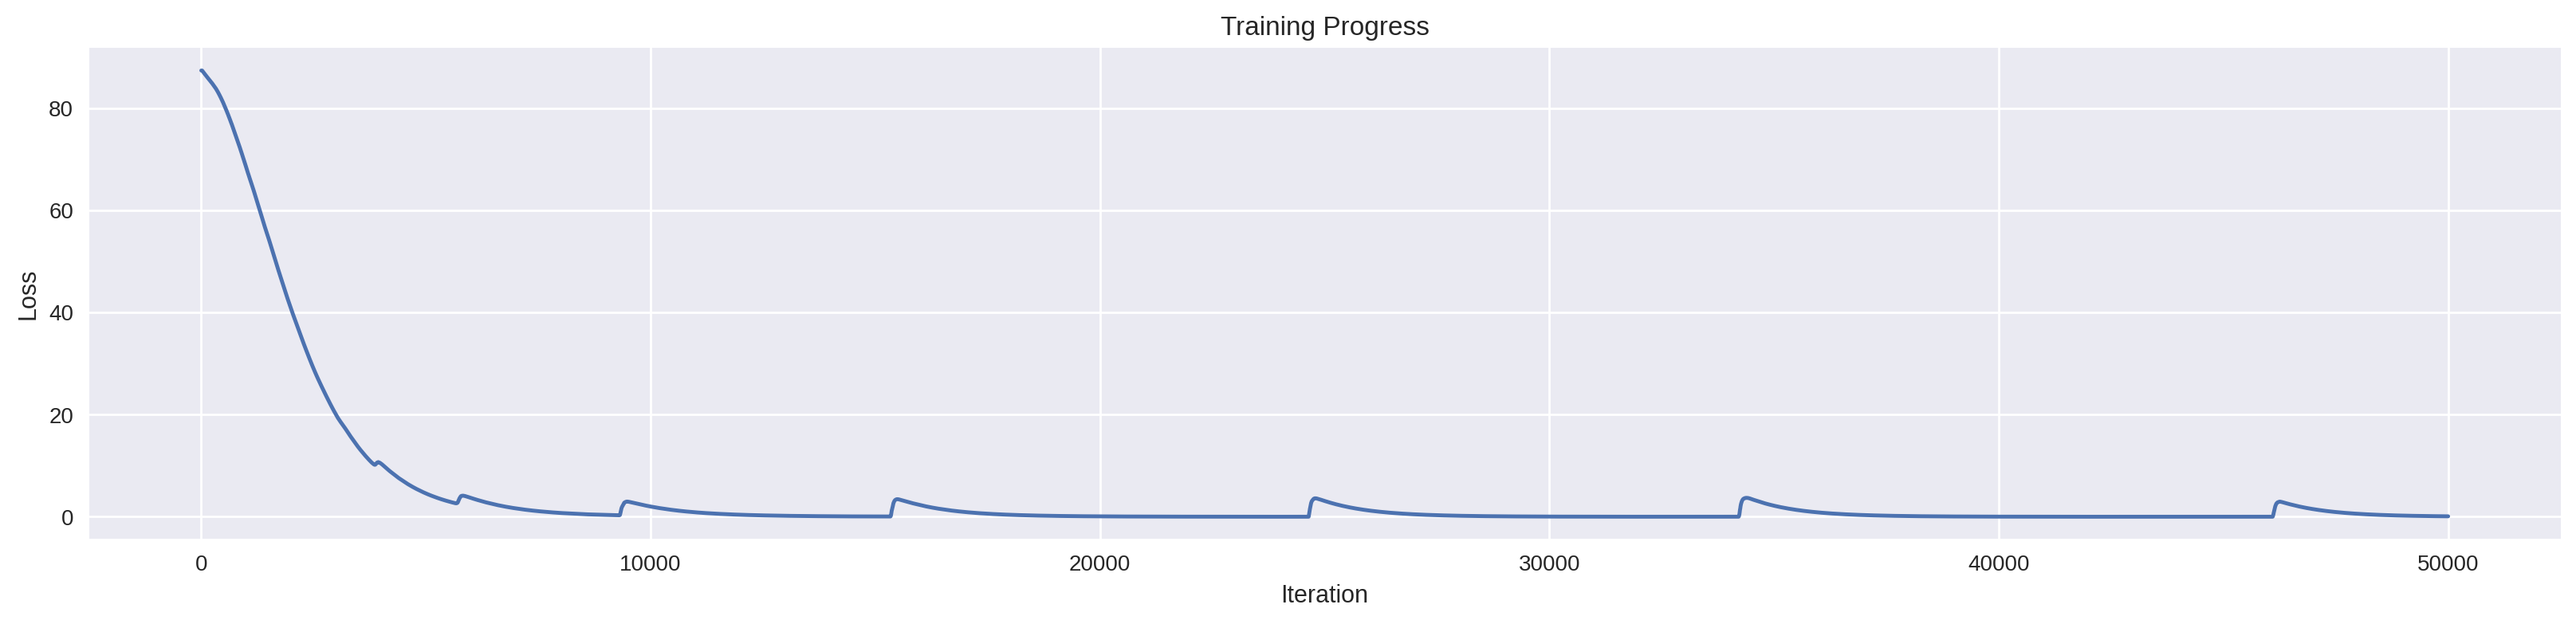

In [16]:
plt.figure(figsize=(20, 4))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST DIFFERENT SEEDS__

In [17]:
seed_chars = ['T', 'A', 'H', 'W', 'I']
for char in seed_chars:
    generated = sample(char, n_chars=150)
    print(char, ':', generated)
    print("-" * 60)

T : Thed ret leoked until the water came up high enough.

At last, the crow could drink the water.
He felt refreshed and flew away happily he flew down and
------------------------------------------------------------
A : At lying inssea.



gtw a lying un search of water. The sun was shining brightly, and the poor crow was feeling tired and weak.

After flying for a lon
------------------------------------------------------------
H : He water at the bottom, but his beak could not reach it.

The crow thought for a moment. Then he got an idea!

He started picking up small pebbles one 
------------------------------------------------------------
W : was shonished and flew away happily he by tte was a lowt anch the bottom, but his beak could not reach it.

The crow thought for a moment. Then he got 
------------------------------------------------------------
I : ing up small pebbles one by one and dropped them into the pitcher. Slowly, the water began to rise. The crow continued dropping 

## **SUMMARY**
### **Key Takeaways:**
1. **Hidden State = Memory**: The hidden state $\mathbf{h}_t$ encodes all information seen so far
2. **BPTT = Unrolled Backprop**: Treat RNN as deep feedforward network, backprop through time for all timestamps
3. **Gradient Clipping is Essential**: RNNs suffer from exploding/vanishing gradients
4. **Hidden State Continuity Matters**: Maintaining $\mathbf{h}_t$ across sequences enables long-range learning
5. **Sampling > Greedy Encoding**: Introduces diversity in generation
### **Limitations of Vanilla RNNs:**
- **Vanishing Gradients**: Can't learn very long-range dependencies (>20-30 timesteps)  
- **Slow Training**: Sequential nature prevents parallelization  
- **Limited Memory**: Fixed-size hidden state bottleneck  
### **Modern Improvements:**
- **LSTMs (Long Short-Term Memory)**: Solve vanishing gradient with gating mechanisms  
- **GRUs (Gated Recurrent Units)**: Simpler than LSTM, similar performance
- **Transformers**: Use attention, fully parallelizable, now dominant in NLP
### **References:**
1. Karpathy, A. (2015). *The Unreasonable Effectiveness of RNNs*. [Blog Post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
2. Elman, J. (1990). *Finding Structure in Time*. Cognitive Science, 14(2), 179-211.
3. Rumelhart, D. E., et al. (1986). *Learning representations by back-propagating errors*. Nature, 323(6088), 533-536.
4. Kingma, D. P., & Ba, J. (2014). *Adam: A Method for Stochastic Optimization*. arXiv:1412.6980.
### **Further Reading:**
1. Karpathy, A. (2015). [The Unreasonable Effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
2. Hochreiter & Schmidhuber (1997). Long Short-Term Memory. Neural Computation.
3. Cho et al. (2014). Learning Phrase Representations using RNN Encoder-Decoder for SMT.
4. Vaswani et al. (2017). Attention Is All You Need. NeurIPS.
5. Goodfellow et al. (2016). Deep Learning. Chapter 10: Sequence Modeling.